In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches


# Training data preparation 

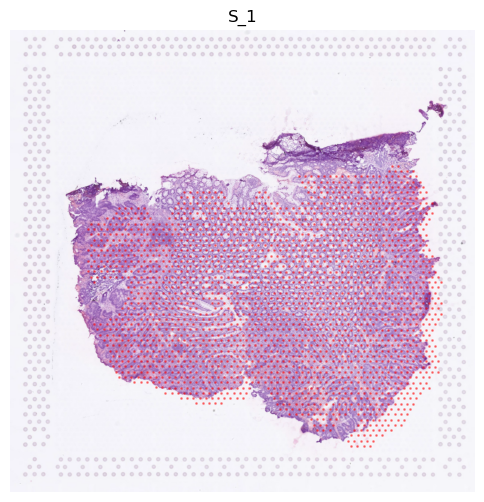

In [5]:
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [10]:
image.shape

(2000, 1974, 3)

In [6]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

S_1
S_2
S_3
S_4
S_5
S_6


,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,1554,1297,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,0.020029,...,1.009572e-03,2.068237,0.121361,0.007344,0.000017,0.036891,0.035934,0.118937,0.001472,0.050057
1,462,1502,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,0.001711,...,6.918171e-04,0.014442,0.000238,0.024071,0.000023,0.217589,0.100662,0.004027,0.004122,0.049491
2,1488,1548,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,0.000114,...,9.577447e-05,0.149792,0.001401,0.000699,0.000009,0.024491,0.018810,0.004171,0.000425,0.015348
3,1725,1182,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,0.010154,...,1.964150e-03,0.142549,0.002036,0.047165,0.000022,0.180372,0.202981,0.003709,0.001845,0.116022
4,581,1113,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,0.000468,...,7.189078e-05,0.005920,0.000048,0.006359,0.000585,0.052661,0.032168,0.000107,0.000107,0.013103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,1055,701,0.047236,0.112721,0.052490,0.002092,0.000913,0.393805,0.045220,0.013414,...,7.530558e-03,0.559967,0.154793,0.133587,0.000013,0.051041,0.113100,0.003147,0.004971,0.128265
2193,1225,862,0.070764,0.119310,0.193938,0.001239,0.003851,0.588956,0.037731,0.004072,...,3.219223e-02,0.667076,0.094247,0.136623,0.000009,0.050518,0.119685,0.027743,0.016413,0.287171
2194,765,1479,0.194491,0.048068,0.150061,0.002978,0.119206,0.000213,0.005332,0.000078,...,2.628421e-04,0.000273,0.000022,0.000027,0.000042,0.029386,0.019977,0.000039,0.000119,0.006778
2195,607,1525,0.002968,0.151899,0.015931,0.000071,1.354983,0.000152,0.019254,0.001267,...,1.377452e-03,0.003754,0.001420,0.088000,0.000536,0.073240,0.113631,0.009040,0.000090,0.025716


In [ ]:
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch_geometric
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
# 用來儲存每個 slide 的 edge_index
def compute_edge_index(coords, radius=128):
    """
    計算每個 batch 的 edge_index（鄰接關係）
    同時顯示每個點的鄰居數量
    """
    kdtree = KDTree(coords)
    edge_list = []
    
    # 用來統計每個點的鄰居數量
    neighbor_counts = []
    
    for i, coord in enumerate(coords):
        neighbors = kdtree.query_ball_point(coord, r=radius)  # 查找半徑為 radius 的鄰居
        
        # 計算當前點的鄰居數量
        neighbor_counts.append(len(neighbors))
        
        # 將所有鄰居添加到 edge_list 中
        for j in neighbors:
            if i != j:
                edge_list.append([i, j])

    # 顯示每個點的鄰居數量
    for i, count in enumerate(neighbor_counts):
        print(f"Point {i} has {count} neighbors.")
            # 將邊列表轉換為 PyG 格式
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    return edge_index

normal_coords = []
slide_edge_indices = {}

# 預先計算每個 slide 的 edge_index 並儲存
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue
        
        # 讀取這個 slide 的 DataFrame
        df = train_spot_tables[slide_id]
        
        # 提取 (x, y) 座標並進行標準化
        coords = df[['x', 'y']].values
        scaler = MinMaxScaler()
        coords_normalized = scaler.fit_transform(coords)  # 將座標標準化到 [0, 1] 範圍內
                # 儲存標準化後的 (x, y) 座標
        df[['x_normalized', 'y_normalized']] = coords_normalized
        normal_coords.append((coords_normalized))  # Wrap the values in a tuple

        # 計算原始座標的半徑
        original_radius = 64  # 原始的 radius 值（像素）

        # 計算標準化後的 radius
        # 假設你的 x, y 範圍分別是 [min_x, max_x] 和 [min_y, max_y]
        min_x, max_x = np.min(coords[:, 0]), np.max(coords[:, 0])
        print(f"min_x: {min_x}, max_x: {max_x}")
        min_y, max_y = np.min(coords[:, 1]), np.max(coords[:, 1])
        print(f"min_y: {min_y}, max_y: {max_y}")
        # 計算標準化後的半徑
        normalized_radius_x = original_radius / (max_x - min_x)
        normalized_radius_y = original_radius / (max_y - min_y)
        print(f"normalized_radius_x: {normalized_radius_x}, normalized_radius_y: {normalized_radius_y}")
        # 你可以選擇平均這兩個來得到一個統一的標準化半徑
        normalized_radius = (normalized_radius_x + normalized_radius_y) / 2

        # 計算 `edge_index` 並儲存
        edge_index = compute_edge_index(coords_normalized, radius=normalized_radius)
        slide_edge_indices[slide_id] = edge_index
        
        # 更新 `train_spot_tables`，儲存標準化後的 DataFrame
        train_spot_tables[slide_id] = df

# 顯示更新後的 `train_spot_tables`
for slide_id in slide_ids:
    print(f"Updated table for slide {slide_id}:")
    print(train_spot_tables[slide_id].head())


min_x: 331, max_x: 1830
min_y: 587, max_y: 1800
normalized_radius_x: 0.04269513008672448, normalized_radius_y: 0.05276174773289365
Point 0 has 19 neighbors.
Point 1 has 9 neighbors.
Point 2 has 19 neighbors.
Point 3 has 20 neighbors.
Point 4 has 20 neighbors.
Point 5 has 21 neighbors.
Point 6 has 22 neighbors.
Point 7 has 21 neighbors.
Point 8 has 21 neighbors.
Point 9 has 16 neighbors.
Point 10 has 19 neighbors.
Point 11 has 21 neighbors.
Point 12 has 11 neighbors.
Point 13 has 19 neighbors.
Point 14 has 22 neighbors.
Point 15 has 22 neighbors.
Point 16 has 19 neighbors.
Point 17 has 19 neighbors.
Point 18 has 21 neighbors.
Point 19 has 18 neighbors.
Point 20 has 20 neighbors.
Point 21 has 21 neighbors.
Point 22 has 20 neighbors.
Point 23 has 19 neighbors.
Point 24 has 21 neighbors.
Point 25 has 17 neighbors.
Point 26 has 16 neighbors.
Point 27 has 21 neighbors.
Point 28 has 21 neighbors.
Point 29 has 20 neighbors.
Point 30 has 20 neighbors.
Point 31 has 19 neighbors.
Point 32 has 21 

## calculate tile_size

In [39]:
# 預先計算每個 slide 的 edge_index 並儲存
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue
        
        # 讀取這個 slide 的 DataFrame
        df = train_spot_tables[slide_id]
        
        # 提取 (x, y) 座標並進行標準化
        coords = df[['x', 'y']].values
        edge_index = compute_edge_index(coords, radius=64)
        slide_edge_indices[slide_id] = edge_index
        
        # 更新 `train_spot_tables`，儲存標準化後的 DataFrame
        train_spot_tables[slide_id] = df

# 顯示更新後的 `train_spot_tables`
for slide_id in slide_ids:
    print(f"Updated table for slide {slide_id}:")
    print(train_spot_tables[slide_id].head())

Point 0 has 18 neighbors.
Point 1 has 9 neighbors.
Point 2 has 19 neighbors.
Point 3 has 19 neighbors.
Point 4 has 19 neighbors.
Point 5 has 19 neighbors.
Point 6 has 19 neighbors.
Point 7 has 19 neighbors.
Point 8 has 19 neighbors.
Point 9 has 16 neighbors.
Point 10 has 19 neighbors.
Point 11 has 19 neighbors.
Point 12 has 11 neighbors.
Point 13 has 17 neighbors.
Point 14 has 19 neighbors.
Point 15 has 19 neighbors.
Point 16 has 19 neighbors.
Point 17 has 19 neighbors.
Point 18 has 19 neighbors.
Point 19 has 18 neighbors.
Point 20 has 19 neighbors.
Point 21 has 19 neighbors.
Point 22 has 19 neighbors.
Point 23 has 19 neighbors.
Point 24 has 19 neighbors.
Point 25 has 17 neighbors.
Point 26 has 16 neighbors.
Point 27 has 19 neighbors.
Point 28 has 19 neighbors.
Point 29 has 19 neighbors.
Point 30 has 19 neighbors.
Point 31 has 19 neighbors.
Point 32 has 19 neighbors.
Point 33 has 19 neighbors.
Point 34 has 17 neighbors.
Point 35 has 19 neighbors.
Point 36 has 19 neighbors.
Point 37 has

In [84]:
slide_edge_indices

{'S_1': tensor([[   0,    0,    0,  ..., 2196, 2196, 2196],
         [ 141,  413, 2018,  ...,  657, 1896, 2183]]),
 'S_2': tensor([[   0,    0,    0,  ..., 2269, 2269, 2269],
         [ 357, 1276, 2087,  ..., 1356,  337, 1456]]),
 'S_3': tensor([[  0,   0,   0,  ..., 689, 689, 689],
         [419, 649,  18,  ..., 587, 451, 598]]),
 'S_4': tensor([[   0,    0,    0,  ..., 1186, 1186, 1186],
         [ 957,  755,  534,  ...,  564,  310,  363]]),
 'S_5': tensor([[   0,    0,    0,  ..., 1676, 1676, 1676],
         [1539,  361,  292,  ..., 1091,  599, 1419]]),
 'S_6': tensor([[  0,   0,   0,  ..., 327, 327, 327],
         [312, 317,  94,  ..., 285, 211, 249]])}

In [58]:
import torch


torch.save({
    'normal_coords':normal_coords,
    'slide_edge_indices': slide_edge_indices
}, "train_slide_edge_indices.pt")

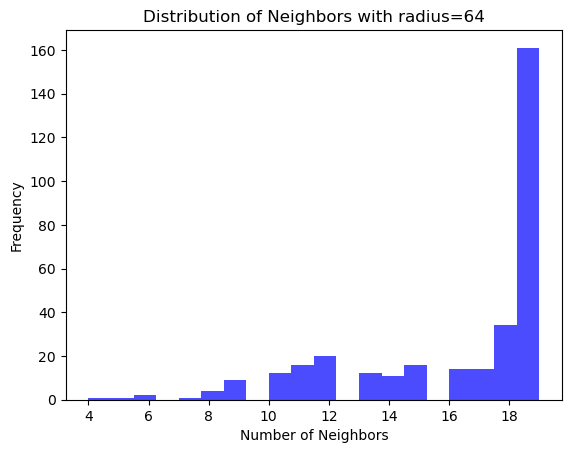

Point 0 has 19 neighbors.
Point 1 has 19 neighbors.
Point 2 has 12 neighbors.
Point 3 has 16 neighbors.
Point 4 has 19 neighbors.
Point 5 has 9 neighbors.
Point 6 has 19 neighbors.
Point 7 has 19 neighbors.
Point 8 has 19 neighbors.
Point 9 has 18 neighbors.
Point 10 has 19 neighbors.
Point 11 has 18 neighbors.
Point 12 has 14 neighbors.
Point 13 has 19 neighbors.
Point 14 has 17 neighbors.
Point 15 has 12 neighbors.
Point 16 has 19 neighbors.
Point 17 has 14 neighbors.
Point 18 has 19 neighbors.
Point 19 has 19 neighbors.
Point 20 has 19 neighbors.
Point 21 has 19 neighbors.
Point 22 has 11 neighbors.
Point 23 has 19 neighbors.
Point 24 has 8 neighbors.
Point 25 has 11 neighbors.
Point 26 has 19 neighbors.
Point 27 has 19 neighbors.
Point 28 has 19 neighbors.
Point 29 has 19 neighbors.
Point 30 has 19 neighbors.
Point 31 has 19 neighbors.
Point 32 has 15 neighbors.
Point 33 has 12 neighbors.
Point 34 has 12 neighbors.
Point 35 has 18 neighbors.
Point 36 has 19 neighbors.
Point 37 has 

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree

def compute_edge_index_and_neighbor_counts(coords, radius=128):
    """
    計算每個 batch 的 edge_index（鄰接關係）和鄰居數量
    """
    kdtree = KDTree(coords)
    edge_list = []
    neighbor_counts = []
    
    for i, coord in enumerate(coords):
        neighbors = kdtree.query_ball_point(coord, r=radius)
        neighbor_counts.append(len(neighbors))  # 記錄每個點的鄰居數量
        for j in neighbors:
            if i != j:
                edge_list.append([i, j])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index, neighbor_counts

# 假設有一些 (x, y) 座標np.array([[100, 200], [120, 220], [300, 400], [500, 600], [130, 230]])
coords = df[['x', 'y']].values

# 計算 `edge_index` 和每個點的鄰居數量
radius = 64
edge_index, neighbor_counts = compute_edge_index_and_neighbor_counts(coords, radius)

# 繪製鄰居數量的分佈圖
plt.hist(neighbor_counts, bins=20, color='blue', alpha=0.7)
plt.xlabel('Number of Neighbors')
plt.ylabel('Frequency')
plt.title(f'Distribution of Neighbors with radius={radius}')
plt.show()

# 打印每個點的鄰居數量
for i, count in enumerate(neighbor_counts):
    print(f"Point {i} has {count} neighbors.")


## show image

# Test data preparation

In [82]:


test_normal_coords = []
test_slide_edge_indices = {}

# 預先計算每個 slide 的 edge_index 並儲存
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    slide_ids = list(test_spots.keys())  # Convert KeysView to a list
    
    for slide_id in slide_ids:
        print(f"Processing slide: {slide_id}")
        
        # Get the spot array for the current slide
        spot_array = np.array(test_spots[slide_id])
        test_spot_table = pd.DataFrame(spot_array)

        # 提取 (x, y) 座標並進行標準化
        coords = test_spot_table[['x', 'y']].values
        scaler = MinMaxScaler()
        coords_normalized = scaler.fit_transform(coords)  # 將座標標準化到 [0, 1] 範圍內
        
        # 儲存標準化後的 (x, y) 座標
        test_spot_table[['x_normalized', 'y_normalized']] = coords_normalized
        test_normal_coords.append(coords_normalized)  # Wrap the values in a tuple

        # 計算原始座標的半徑
        original_radius = 64  # 原始的 radius 值（像素）

        # 計算標準化後的 radius
        min_x, max_x = np.min(coords[:, 0]), np.max(coords[:, 0])
        print(f"min_x: {min_x}, max_x: {max_x}")
        min_y, max_y = np.min(coords[:, 1]), np.max(coords[:, 1])
        print(f"min_y: {min_y}, max_y: {max_y}")

        # 計算標準化後的半徑
        normalized_radius_x = original_radius / (max_x - min_x)
        normalized_radius_y = original_radius / (max_y - min_y)
        print(f"normalized_radius_x: {normalized_radius_x}, normalized_radius_y: {normalized_radius_y}")
        
        # 你可以選擇平均這兩個來得到一個統一的標準化半徑
        normalized_radius = (normalized_radius_x + normalized_radius_y) / 2

        # 計算 `edge_index` 並儲存
        edge_index = compute_edge_index(coords_normalized, radius=normalized_radius)
        test_slide_edge_indices[slide_id] = edge_index

# 顯示更新後的 `test_slide_edge_indices`
test_slide_edge_indices


Processing slide: S_7
min_x: 380, max_x: 1639
min_y: 440, max_y: 1769
normalized_radius_x: 0.050833995234312944, normalized_radius_y: 0.04815650865312265
Point 0 has 18 neighbors.
Point 1 has 19 neighbors.
Point 2 has 19 neighbors.
Point 3 has 19 neighbors.
Point 4 has 19 neighbors.
Point 5 has 17 neighbors.
Point 6 has 19 neighbors.
Point 7 has 16 neighbors.
Point 8 has 19 neighbors.
Point 9 has 19 neighbors.
Point 10 has 19 neighbors.
Point 11 has 7 neighbors.
Point 12 has 16 neighbors.
Point 13 has 19 neighbors.
Point 14 has 19 neighbors.
Point 15 has 16 neighbors.
Point 16 has 19 neighbors.
Point 17 has 18 neighbors.
Point 18 has 19 neighbors.
Point 19 has 19 neighbors.
Point 20 has 19 neighbors.
Point 21 has 19 neighbors.
Point 22 has 19 neighbors.
Point 23 has 18 neighbors.
Point 24 has 19 neighbors.
Point 25 has 19 neighbors.
Point 26 has 19 neighbors.
Point 27 has 12 neighbors.
Point 28 has 19 neighbors.
Point 29 has 19 neighbors.
Point 30 has 19 neighbors.
Point 31 has 6 neigh

{'S_7': tensor([[   0,    0,    0,  ..., 2087, 2087, 2087],
         [1141, 1926,  469,  ..., 1793, 1013,  560]])}

In [80]:
## Make sure I have all the data     

print(f"Total number of spots across all slides: {len(test_spot_table)}")

print(f"The spots in our preprocessing datasets: {len(test_normal_coords[0])}")

Total number of spots across all slides: 2088
The spots in our preprocessing datasets: 2088


In [85]:
import torch


torch.save({
    'normal_coords':test_normal_coords,
    'slide_edge_indices': test_slide_edge_indices
}, "test_slide_edge_indices.pt")